In [22]:
import statistics
import time
import torch
import tqdm
import torch.utils.data as data
import torchvision.utils as tutils
import torchvision

from matplotlib import pyplot as plt
from statistics import mean
from torch import nn, optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
from PIL import Image

In [12]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00005

# Lower for clipping parameter of Critic(Discriminator)
clamp_lower = -0.01
# Upper for clipping parameter of Critic(Discriminator)
clamp_upper = 0.01

# number of D iters per each G iter
n_critic = 5

cuda:0


# Generator
* same as DCGAN.

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Descriminator
* Difference between WGAN and DCGAN is activation function.
* In WGAN, last activation function sigmoid is removed.

In [3]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Initialize weight.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(z_dim=100, image_size=64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Dataloader

In [7]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]
)

trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
print(len(trainloader))

118


torch.Size([512, 1, 64, 64])


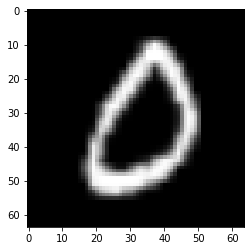

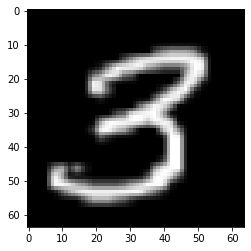

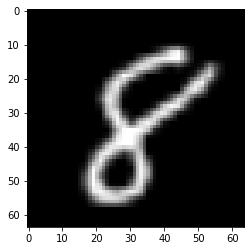

In [9]:
batch_iterator = iter(trainloader)
images, labels = next(batch_iterator)
print(images.size())

plt.imshow(images[0].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[1].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[2].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

# Optimizer
* use RMSProop.
* ADAM is not effective in WAGN.

In [14]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(D.parameters(), lr=lr)
optimizerG = optim.RMSprop(G.parameters(), lr=lr)

# Training

In [28]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

D.to(device)
G.to(device)

D.train()
G.train()

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(trainloader):
        
        #############################
        # 3. Repeat [n_critic] times
        #############################
        for n in range(n_critic):

            ############################
            # 1. Update D network
            ###########################
            D.zero_grad()
            # Format batch
            real_cpu = imgs.to(device)
            b_size = real_cpu.size(0)
            # Forward pass real batch through D
            output = D(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = torch.mean(output)
            # Calculate gradients for D in backward pass
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = G(noise)
            # Classify all fake batch with D
            output = D(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = torch.mean(output)
            # Calculate the gradients for this batch
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = - errD_real + errD_fake
            errD.backward()
            # Update D
            optimizerD.step()

            ##################################
            # 2. Clip weights of discriminator
            ##################################
            for p in D.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

        ############################
        # 4. Update G network
        ###########################
        G.zero_grad()
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = - torch.mean(output)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(tutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    

Starting Training Loop...
[1/20][0/118]	Loss_D: -715.3423	Loss_G: 206.3254	D(x): 678.2192	D(G(z)): -37.1231 / -206.3254
[1/20][50/118]	Loss_D: -698.8673	Loss_G: -255.3919	D(x): 443.4698	D(G(z)): -255.3975 / 255.3919
[1/20][100/118]	Loss_D: -747.9230	Loss_G: 264.7727	D(x): 664.9750	D(G(z)): -82.9480 / -264.7727
[2/20][0/118]	Loss_D: -724.3359	Loss_G: 172.9557	D(x): 764.4697	D(G(z)): 40.1338 / -172.9557


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

# Visualize Result

In [ ]:
vis_batch_size = 8
z_dim = 100

fixed_z = torch.randn(vis_batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G.eval()
fake_images = G(fixed_z.to(device))

batch_iterator = iter(trainloader)
imges, _ = next(batch_iterator)

fig = plt.figure(figsize=(12, 4))
for i in range(0, 8):
    plt.subplot(2, 8, i+1)
        
    plt.imshow(imges[i].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
    
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')